## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
#Take care of all the imports here
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

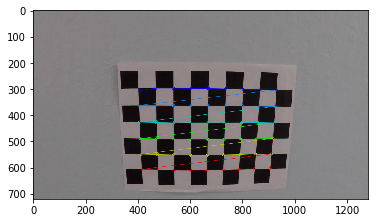

In [2]:
# Camera calibration

#prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners...[Reji] to be suppressed later
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
       
 # Using the image points and object points get the camera matrix, distortion coefficents etc
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Apply color and gradient thresholds to get the lanes

Text(0.5,1,'undistorted')

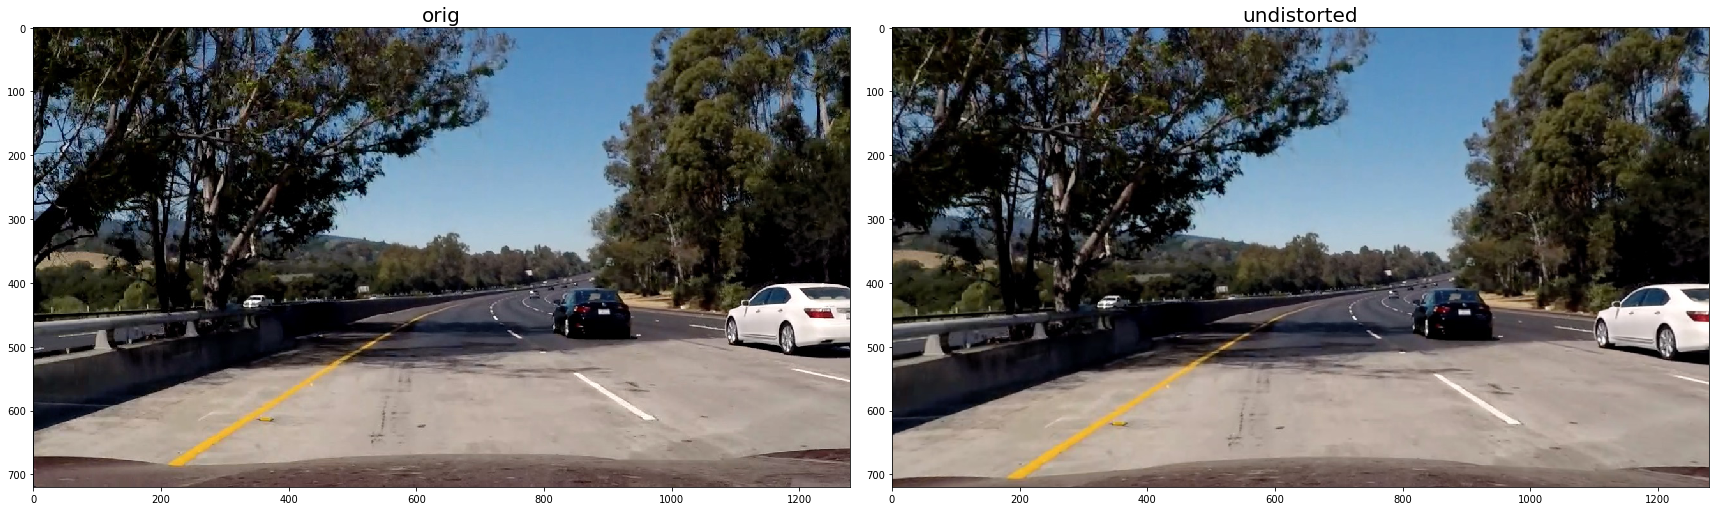

In [4]:
#img=plt.imread('./test_images/test3.jpg')
#img=plt.imread('camera_cal/calibration20.jpg')
#img=plt.imread('./test_images/straight_lines1.jpg')
img=plt.imread('color-shadow-example.jpg')

undst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('orig', fontsize=20)
ax2.imshow(undst)
ax2.set_title('undistorted', fontsize=20)

In [5]:
#Apply color and sobel gradients to extract lanes from the undistorted images
#Using the code from the quizes and lessons

#Define all the helper functions
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobel = np.sqrt( (np.square(abs_sobelx) + np.square(abs_sobely)))
    scaled_sobel = np.uint8(abs_sobel*255/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx= cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad_dir = np.arctan2(abs_sobely,abs_sobelx)
    
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1
    return binary_output

def hls_select(img, channel="S",thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    if channel == "S":
        C = hls[:,:,2]
    elif channel == "L":
        C = hls[:,:,2]
    
    binary_output=np.zeros_like(C)
    binary_output[(C >= thresh[0]) & (C <= thresh[1])] = 1
    return binary_output

In [ ]:
#Get all the gradients

###Test cell to try out various combinations...spent couple of days here..need to come back and do a better job here


#Calculated all kinds of gradients and color masks and spent considerable amount of time doing trail and error...
#grady, dir_binary and mag_binary are not giving much value. 
#Keeping only the Sobel grad x for now. Keeping the others in comments in case needed later on
#grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=19, thresh=(20, 100))
#mag_binary = mag_thresh(dst, sobel_kernel=19, mag_thresh=(20, 100))
#dir_binary = dir_threshold(undst, sobel_kernel=15, thresh=(np.pi/6, np.pi/2))

#gradx = abs_sobel_thresh(undst, orient='x', sobel_kernel=17, thresh=(10, 200))

#S channel is needed for sure...still not sure if this is the right threshold.
#s_channel = hls_select(undst,channel="S",thresh=(100, 255))

#l_channel = hls_select(undst,channel="L",thresh=(120,255))

#Get the combined mask
#combined_grad_dir = np.zeros_like(dir_binary)
#combined_grad_dir[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

#combined_grad_channel = np.zeros_like(s_channel)
#combined_grad_channel[(s_channel == 1) | (gradx == 1)] = 1

#dir_grad = np.zeros_like(gradx)
#dir_grad[((gradx ==1) | (dir_grad == 1))] = 1

#color_threshold = 150
#R = undst[:,:,0]
#G = undst[:,:,1]
#rgb_channel = (R > color_threshold) & (G > color_threshold)

#c_channel = np.zeros_like(w_channel)
#c_channel[(w_channel == 1) | (y_channel ==1)] = 1

#combined = np.zeros_like(s_channel)
#combined[((c_channel == 1) | (combined_grad_channel ==1))] = 1
#combined[((s_channel == 1) & (l_channel ==1)) |(gradx == 1)] = 1
#combined[(((rgb_channel) == 1 & (l_channel == 1)) & ((s_channel == 1) | (gradx == 1)))] = 1
#gradx = abs_sobel_thresh(undst, orient='x', sobel_kernel=17, thresh=(10, 200))

In [6]:
#Take the undistored image and combine all the possible gradients and thresholds to get an image.

def final_combined(undst):
    
    #Get the Sobel X gradient
    gradx = abs_sobel_thresh(undst, orient='x', sobel_kernel=3, thresh=(20, 150))
    
    # check the red and green channels...(based on some experimentation and search online..ignored first but
    #then helped in some sections of the images and videos)
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_channel = np.zeros_like(R)
    rgb_channel = (R > color_threshold) & (G > color_threshold)
    
    #Get the S channel
    s_channel = hls_select(undst,channel="S",thresh=(110, 255))
    
    #Get the L channel....again from reading online after issues in detecting the yellow lines in some images
    l_channel = hls_select(undst,channel="L",thresh=(120,255))
    
    #Combine all these now..
    #color_channel[(((rgb_channel ==1) | (l_channel ==1)) & ( (s_channel ==1) | (gradx ==1) ))] = 1
    color_channel[( (s_channel ==1) | (gradx ==1) )] = 1
    
    return color_channel,s_channel, l_channel, rgb_channel, gradx

##Get the combined gradient and color threshold based image back.
combined, s_channel, l_channel, rgb_channel, gradx =final_combined(undst)

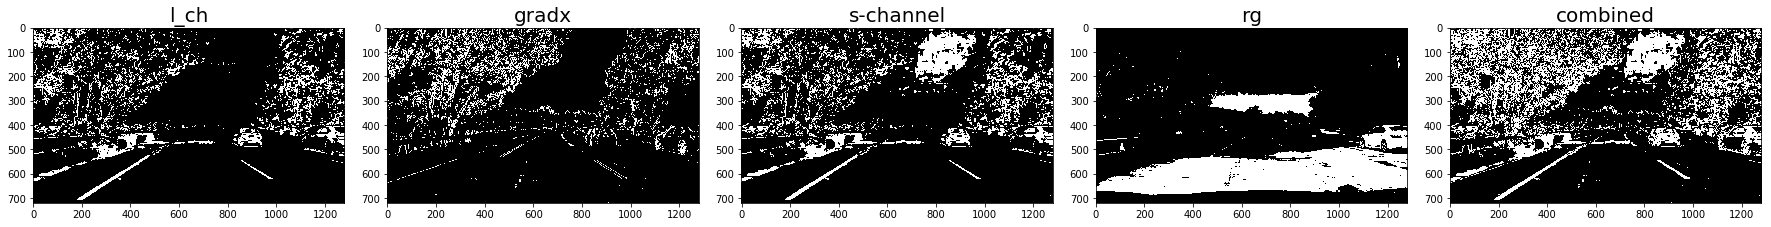

In [7]:
# Plot the intermdiate results for trial and error
f, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1,5,figsize=(24, 9))
f.tight_layout()
#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=50)
ax1.imshow(l_channel, cmap='gray')
ax1.set_title('l_ch', fontsize=20)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('gradx', fontsize=20)
ax3.imshow(s_channel, cmap='gray')
ax3.set_title('s-channel', fontsize=20)
ax4.imshow(rgb_channel,cmap="gray")
ax4.set_title("rg", fontsize=20)
ax5.imshow(combined,cmap="gray")
ax5.set_title("combined", fontsize=20)
plt.subplots_adjust(left=0., right=1.0, top=0.9, bottom=0.)

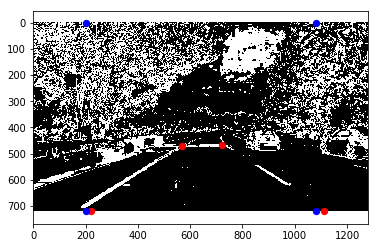

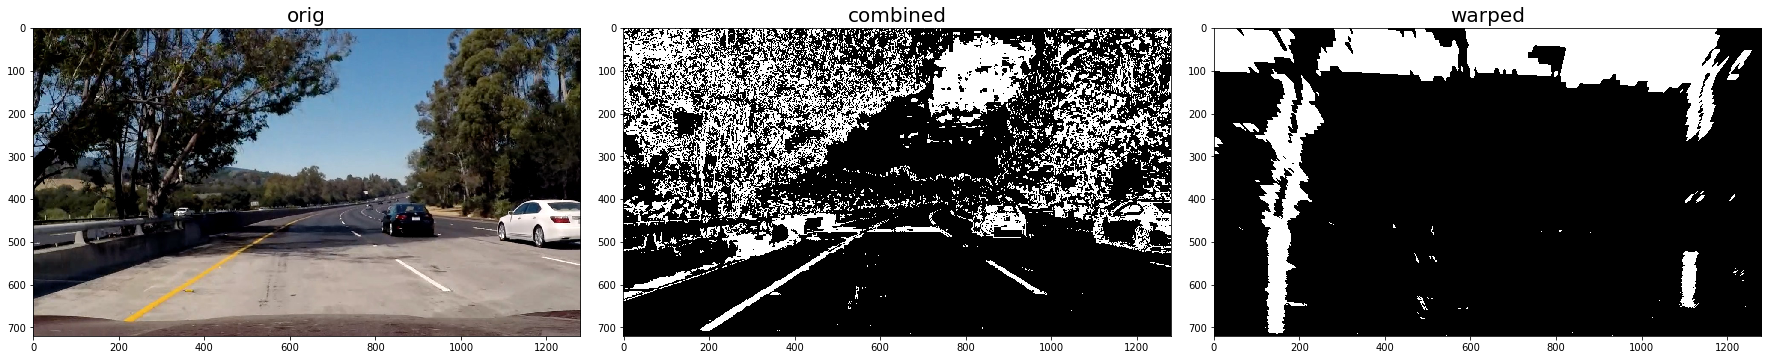

In [8]:
#Apply perspective transform on the images
#In order to get the source and destination points, used the straight lines 1 image and marked out manually the rectangle 
#and used to map it to the four corners of top down view..lets see what happens

#What is the shape of the image now?
#print(combined.shape)

img_size = (combined.shape[1], combined.shape[0])

implot = plt.imshow(combined,cmap="gray")

#undst_img_size= (undst.shape[1],undst.shape[0])

#define src as the four points on the two lines in the combined binary point
#src = np.float32([[205,720], [1100,720], [505,510], [790,510]])
src = np.float32([[220,720], [1110,720], [570,470], [720,467]])
#print(src[:,0])

dst = np.float32([(200, 720), (1080, 720), (200, 1), (1080, 1)])


plt.scatter(x=src[:,0], y=src[:,1], c='r', s=40)
plt.scatter(x=dst[:,0], y=dst[:,1], c='b', s=40)

#get the perspective transform matrix
M = cv2.getPerspectiveTransform(src,dst)
Minv=cv2.getPerspectiveTransform(dst,src)

#warped = cv2.warpPerspective(undst,M,undst_img_size,flags=cv2.INTER_LINEAR)
warped = cv2.warpPerspective(combined,M,img_size,flags=cv2.INTER_LINEAR)

#plot for checking
f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('orig', fontsize=20)
ax2.imshow(combined, cmap='gray')
ax2.set_title('combined', fontsize=20)
ax3.imshow(warped, cmap='gray')
ax3.set_title('warped', fontsize=20)
plt.subplots_adjust(left=0., right=1.0, top=0.9, bottom=0.)

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
          
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix :
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def slide_search(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty, rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, left_fit, right_fit


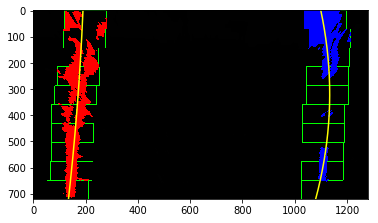

In [10]:
#Call the sliding line functions to see what happens
out_img, left_fitx, right_fitx, left_fit, right_fit = slide_search(warped)

plt.imshow(out_img)

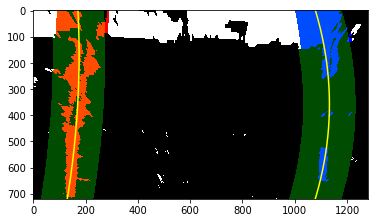

In [11]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx = search_around_poly(warped)

# View your output
plt.imshow(result)

In [12]:
#Global Line objects to track lines
left_fit = None
right_fit = None
fresh_search = False
recent_left_lines = []
recent_right_lines = []

line_diff = 0

def measure_radius_of_curvature(x_values,num_rows):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    ploty = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad      


def poly_fits(nonzerox,nonzeroy,left_lane_inds, right_lane_inds, img_shape):
    
    global left_fit
    global right_fit
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if (leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0):
        return None, None

    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx


def slide_search(binary_warped):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
          
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix :
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    left_fitx, right_fitx = poly_fits(nonzerox,nonzeroy,left_lane_inds, right_lane_inds,binary_warped.shape)


    return left_fitx, right_fitx

def search_around_line(binary_warped):
    #Search around the current lines
        # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    global left_fit
    global right_fit

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx = poly_fits(nonzerox,nonzeroy,left_lane_inds, right_lane_inds,binary_warped.shape)
    
   
    return left_fitx, right_fitx

def average_line(past_lines, current_line):

    frames=10

    if current_line is None:
        if len(past_lines) == 0:
            return past_lines, None
        else:
            return past_lines, past_lines[-1]

    else:
        if len(past_lines) < frames:
            past_lines.append(current_line)
            return past_lines, current_line
        else:
            past_lines.append(current_line)
            past_lines = past_lines[1:]
            current_line = sum(past_lines)/frames
            return past_lines, current_line


def find_lanes(warped_img):
    global fresh_search
    #Check if fresh_search is false
    #If false do a slide_search and make fresh_search as true
    if fresh_search == False:
        fresh_search = True
        left_fitx, right_fitx = slide_search(warped_img)
        #print(left_fitx, right_fitx)
    else:
        #Call search_around_line
        left_fitx, right_fitx = search_around_line(warped_img)
    
    return left_fitx, right_fitx

def check_lines(left_fitx, right_fitx):
    global line_diff
    line_status = True
    if (left_fitx is None or right_fitx is None):
        #return False
        line_status = False
        print("line is empty")
    else:
        #check the diff and compare with what is happening now
        diff = np.mean(right_fitx - left_fitx)
        if line_diff == 0:
            line_diff = diff
            line_status = True
        if (diff < 0.7*line_diff or diff > 1.3*line_diff):
            print("line is of diff length", diff, line_diff)
            line_status = False


    return line_status

def process_image(img):
    
#Global Line objects to track lines
    global left_fit
    global right_fit

    global recent_left_lines
    global recent_right_lines

    global line_diff
    global fresh_search

    #get the image size...we need this everywhere
    img_size=(img.shape[1],img.shape[0])
    
    #Undistort the image using previously calibrated matrices
    undst_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Apply the Sobel gradients and color thresholds to this undistorted image
    #Will need to clean up this to only return the final value
    combined, s_channel, l_channel, rgb_channel, gradx =final_combined(undst_img)
    
    #Apply perspective transform on this image using previously calculated perspective transform
    warped = cv2.warpPerspective(combined,M,img_size,flags=cv2.INTER_LINEAR)
    
    #Lets find the lines
    #If no line detected at this time
    
    out_img = np.dstack((warped, warped, warped))*255
    

    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    num_rows = warped.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)

    left_fitx, right_fitx = find_lanes(warped)

    line_status = check_lines(left_fitx, right_fitx)

    if line_status == False:
        print("line status", line_status)
        #Line is bad
        #Lets try slide search if it was not called earlier
        if fresh_search == True:
            #slide search was already called
            #we have nothing to do but return previous lines if existing
            print("not calling slide since it was already called")
            left_fit = None
            right_fit = None
            fresh_search = False
            #Added a check to see if we have previous lines
            if len(recent_left_lines) == 0 or len(recent_right_lines) == 0:
                #nothing else to do but return the image as is
                return img
            else:
                #we have recent line...lets return the last one
                left_fitx = recent_left_lines[-1]
                right_fitx = recent_right_lines[-1]
        else:
            #slide search was not called earlier
            #lets try a fresh slide search and see what happens
            print("calling slide since search around returned bad lines")
            fresh_search = True
            left_fitx, right_fitx = find_lanes(warped)
            line_status = check_lines(left_fitx, right_fitx)
            if line_status == False:
                #line is still bad
                #do the bad line stuff
                left_fit = None
                right_fit = None
                #Added a check to see if we have previous lines
                if len(recent_left_lines) == 0 or len(recent_right_lines) == 0:
                   #nothing else to do but return the image as is
                   return img
                else:
                   #we have recent line...lets return the last one
                   left_fitx = recent_left_lines[-1]
                   right_fitx = recent_right_lines[-1]
            else:
                #line has come good
                #do the good line stuff
                recent_left_lines, left_fitx = average_line(recent_left_lines, left_fitx)
                recent_right_lines, right_fitx = average_line(recent_right_lines, right_fitx)
                diff = np.mean(right_fitx - left_fitx)
                line_diff = 0.9*line_diff + 0.1*diff
    else:
        #line is good, proceed further with calculations
        recent_left_lines, left_fitx = average_line(recent_left_lines, left_fitx)
        recent_right_lines, right_fitx = average_line(recent_right_lines, right_fitx)
        diff = np.mean(right_fitx - left_fitx)
        line_diff = 0.9*line_diff + 0.1*diff


            
    
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))
    


    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_fitx,num_rows)
    right_curve_rad = measure_radius_of_curvature(right_fitx,num_rows)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_fitx[num_rows-1] + left_fitx[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

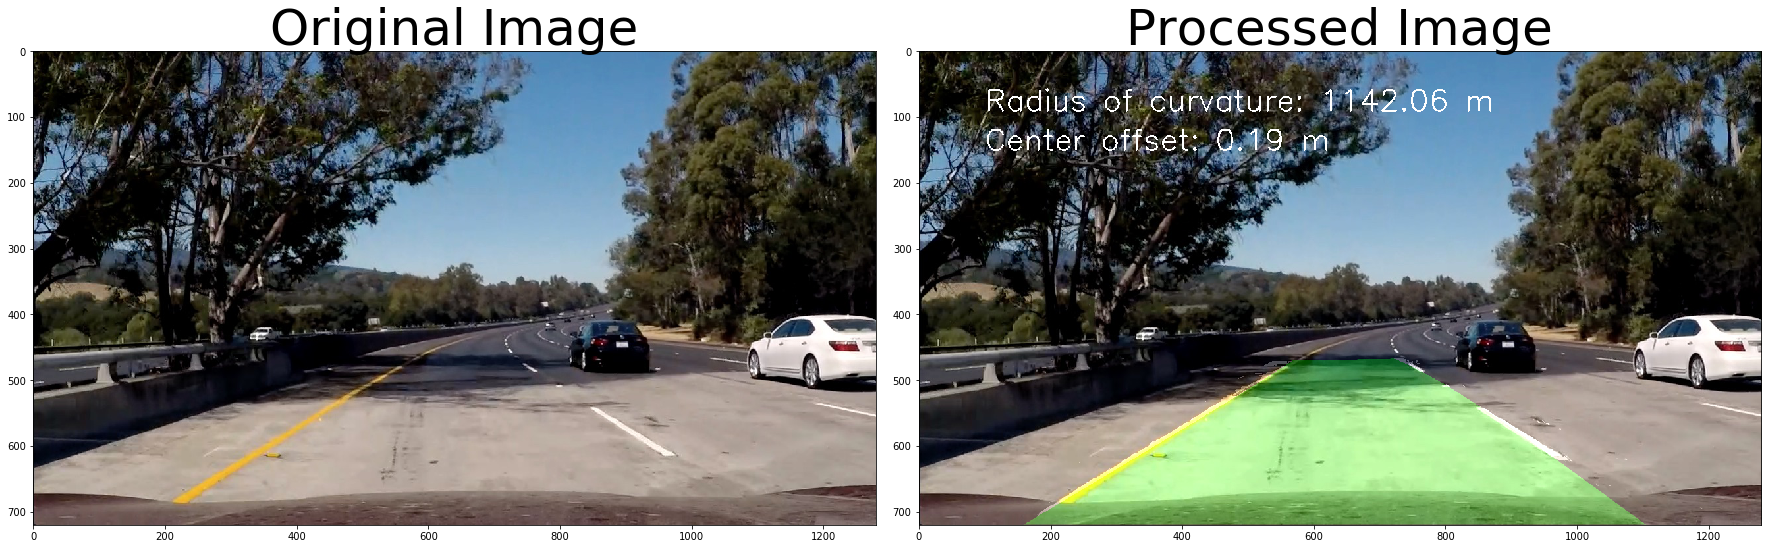

In [13]:
img = plt.imread('color-shadow-example.jpg')

# Reinitialize some global variables.
left_fit = None
right_fit = None
recent_right_lines = []
recent_left_lines = []
line_diff = 0
fresh_search = False

# Apply pipeline
processed = process_image(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Reinitialize some global variables.
left_fit = None
right_fit = None
recent_right_lines = []
recent_left_lines = []
line_diff = 0
fresh_search = False


output = 'project_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 50%|█████     | 633/1261 [02:42<02:48,  3.73it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [16]:
# Reinitialize some global variables.
left_fit = None
right_fit = None
recent_right_lines = []
recent_left_lines = []
line_diff = 0
fresh_search = False


output = 'challenge_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


 15%|█▌        | 74/485 [00:15<01:44,  3.95it/s]

line is of diff length 406.371109589 640.427250891
line status False
not calling slide since it was already called


 27%|██▋       | 129/485 [00:30<01:30,  3.94it/s]

line is of diff length 437.392278389 666.607155028
line status False
not calling slide since it was already called


 27%|██▋       | 130/485 [00:30<01:28,  4.02it/s]

line is of diff length 1672.87320321 666.607155028
line status False
not calling slide since it was already called


 27%|██▋       | 131/485 [00:30<01:31,  3.88it/s]

line is of diff length 2775.98027113 666.607155028
line status False
not calling slide since it was already called


 28%|██▊       | 137/485 [00:32<01:27,  3.99it/s]

line is of diff length 883.808717037 672.00434694
line status False
not calling slide since it was already called


 28%|██▊       | 138/485 [00:32<01:27,  3.95it/s]

line is of diff length 889.027061899 672.00434694
line status False
not calling slide since it was already called


 29%|██▉       | 140/485 [00:33<01:27,  3.93it/s]

line is of diff length -282.518013445 679.33819161
line status False
not calling slide since it was already called


 29%|██▉       | 141/485 [00:33<01:29,  3.85it/s]

line is of diff length -73.7847664252 679.33819161
line status False
not calling slide since it was already called


 29%|██▉       | 142/485 [00:33<01:27,  3.92it/s]

line is of diff length -102.610213918 679.33819161
line status False
not calling slide since it was already called


100%|██████████| 485/485 [02:03<00:00,  3.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 9s, sys: 6.59 s, total: 1min 15s
Wall time: 2min 6s
